# Gold Price Dataset

This is a dataset about gold price from 1970 to 2020

Denny Alvito Ginting
dennyginting73@gmail.com

Resource:
https://www.kaggle.com/datasets/arashnic/learn-time-series-forecasting-from-gold-price 

## Importing Libraries

In [28]:
# Linear Algebra and Dataframe
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modelling
import datetime
import tensorflow as tf
import keras

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DnYAlv/Intermediate_Dicoding/main/Time%20Series/Dataset/gold_price_data.csv')
data.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


## Data Wrangling
We will take a glance at our data, like removing missing values and such.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


In [4]:
data['Date'] = pd.to_datetime(data['Date'])

### Missing Values

In [5]:
data.isnull().sum()

Date     0
Value    0
dtype: int64

> Seems like there's no missing values, therefore we're good to go

## Exploratory Data Analysis

In [6]:
print(f'This dataset contains {data.shape[0]} records and {data.shape[1]} columns')

This dataset contains 10787 records and 2 columns


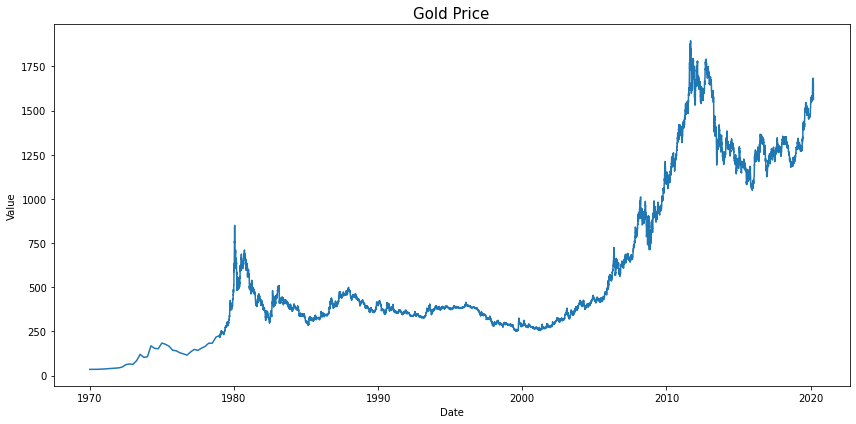

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Value', data=data)
plt.title('Gold Price', fontsize=15)
plt.tight_layout()
plt.show()

## Splitting Dataset
We will split the dataset to 80% Train and 20% for Validation

In [15]:
X = data.Date
y = data.Value

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

In [23]:
train_data = y_train.values.reshape(-1,1)
validation_data = y_test.values.reshape(-1,1)

## Normalize Dataset
Normalizing the dataset can help our model to improve its performance also reducing its weight since the scale of values is reduced.

In [29]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_valid = scaler.transform(validation_data)

## Windowed Dataset
In this process, we will transform our dataset with window method with size of 30 days

In [49]:
def windowed_dataset(dataset, previous_day=30):
    X, y = [], []
    range_of_window = len(dataset) - previous_day

    for i in range(range_of_window):

      # Take the data from i to 30 next days 
      take_data = dataset[i:(i + previous_day), 0]

      # Append to the X list
      X.append(take_data)

      # y is for the last data (next day after 30th day) for each iterate
      y.append(dataset[i + previous_day, 0])

    return np.array(X), np.array(y)

In [50]:
windowed_X_train, windowed_y_train = windowed_dataset(scaled_train)
windowed_X_test, windowed_y_test = windowed_dataset(scaled_valid)

In [58]:
train_set = np.reshape(windowed_X_train, (windowed_X_train.shape[0], 1, windowed_X_train.shape[1]))
test_set = np.reshape(windowed_X_test, (windowed_X_test.shape[0], 1, windowed_X_test.shape[1]))

## Defining the threshold Mean Absolute Error

In [60]:
threshold_mae = (data['Value'].max() - data['Value'].min()) * 10/100
threshold_mae

185.99

## Modelling

In [82]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True,
                         input_shape = (train_set.shape[1],
                                        train_set.shape[2])),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [83]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mae'])

In [84]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.hdf5', monitor= 'val_loss', save_best_only=True)

In [85]:
history = model.fit(train_set, windowed_y_train,
                    epochs=100,
                    validation_data=(test_set, windowed_y_test),
                    callbacks=[checkpoint]
                    )

Epoch 1/100
269/269 [==============================] - 6s 8ms/step - loss: 0.0016 - mae: 0.0230 - val_loss: 2.4830e-04 - val_mae: 0.0176
Epoch 2/100
269/269 [==============================] - 1s 5ms/step - loss: 8.6661e-05 - mae: 0.0083 - val_loss: 1.8936e-04 - val_mae: 0.0151
Epoch 3/100
269/269 [==============================] - 1s 4ms/step - loss: 6.5819e-05 - mae: 0.0072 - val_loss: 1.9585e-04 - val_mae: 0.0158
Epoch 4/100
269/269 [==============================] - 1s 4ms/step - loss: 5.1852e-05 - mae: 0.0064 - val_loss: 1.5351e-04 - val_mae: 0.0141
Epoch 5/100
269/269 [==============================] - 1s 4ms/step - loss: 4.3813e-05 - mae: 0.0059 - val_loss: 2.7492e-04 - val_mae: 0.0206
Epoch 6/100
269/269 [==============================] - 1s 5ms/step - loss: 3.8629e-05 - mae: 0.0056 - val_loss: 7.3354e-05 - val_mae: 0.0090
Epoch 7/100
269/269 [==============================] - 1s 4ms/step - loss: 4.4140e-05 - mae: 0.0061 - val_loss: 7.9660e-05 - val_mae: 0.0098
Epoch 8/100
269/2

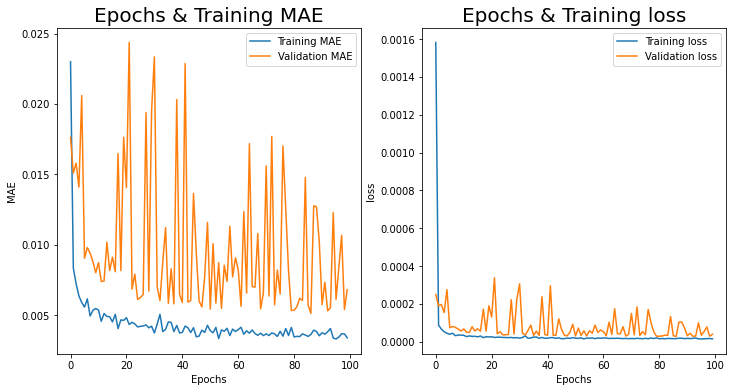

In [86]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history.history['mae'], '-', label = 'Training MAE')
ax[0].plot(history.history['val_mae'], '-', label = 'Validation MAE')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[0].set_title('Epochs & Training MAE', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history.history['loss'], '-', label = 'Training loss')
ax[1].plot(history.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

> Even though the MAE (especially on validation dataset) is fluctuative, it seems that the MAE still smaller than the threshold MAE, which means, our model is good enough for this dataset

## Prediction

In [87]:
pred = model.predict(test_set)

# Reshape to get better information
pred = scaler.inverse_transform(pred.reshape(-1,1))

# Truth value
truth_val = scaler.inverse_transform(windowed_y_test.reshape(-1,1))

67/67 [==============================] - 1s 2ms/step


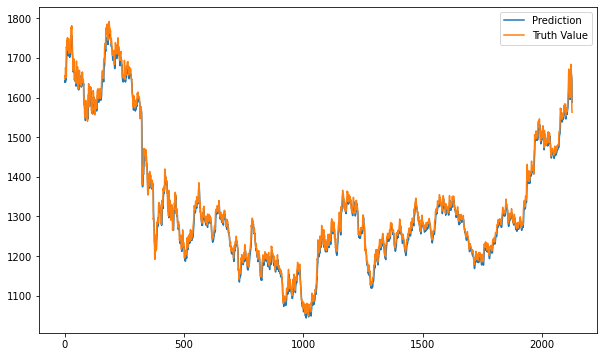

In [88]:
plt.figure(figsize=(10,6))
plt.plot(pred, label='Prediction')
plt.plot(truth_val, label='Truth Value')
plt.legend()
plt.show()

> Okay, so seems like our model done very well on this dataset, we can see that our model can predict for the next 2000+ days and as a simple glance, we hardly see any difference between Prediction and Truth Value. Therefore, this model is generalized well.